In [ ]:
# Reproducibility helpers
import random
import os
import numpy as np
import torch

def seed_everything(seed: int, deterministic: bool = True):
    """Seed python, numpy, torch and related settings for this process/kernel.
    Call once at top of the notebook, and call again inside loops if you want
    reproducible but different runs (e.g. seed by run index).
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    if deterministic:
        # May slow things and some ops raise if deterministic algorithms not available
        try:
            torch.use_deterministic_algorithms(True)
        except Exception:
            # older torch versions may not have this
            pass
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Make the notebook run deterministic for this kernel by default
seed_everything(0)

# For reproducible but different experiment runs, call `seed_everything(d)` inside
# the `for d in range(NUM_RUNS):` loop so run d is deterministic and different from run d+1.

In [1]:
from pathlib import Path
from typing import Tuple, Optional, Literal
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.func import functional_call
from torch import vmap
import copy
from torch.func import stack_module_state
import gpytorch
import matplotlib.pyplot as plt
from math import ceil
from rich.progress import track



from analytical_models.gde_multi import System
from analytical_models import gde_multi
from analytical_models.loaders import load_data, normalize_df_torch

KeyboardInterrupt: 

In [ ]:
class PhModel(torch.nn.Module):
    def __init__(
        self, 
        zlt_mu_stds: Tuple,
        current_target: float = 200,
        dropout: float = 0.1, 
        ldim: int = 64,
    ):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(5, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, 6)
        )

        erc = gde_multi.electrode_reaction_kinetics | {}
        erc['i_0_CO'] = torch.nn.parameter.Parameter(torch.tensor(erc['i_0_CO']))
        erc['i_0_C2H4'] = torch.nn.parameter.Parameter(torch.tensor(erc['i_0_C2H4']))
        erc['i_0_H2b'] = torch.nn.parameter.Parameter(torch.tensor(erc['i_0_H2b']))
        erc['alpha_CO'] = torch.nn.parameter.Parameter(torch.tensor(erc['alpha_CO']))
        erc['alpha_C2H4'] = torch.nn.parameter.Parameter(torch.tensor(erc['alpha_C2H4']))
        erc['alpha_H2b'] = torch.nn.parameter.Parameter(torch.tensor(erc['alpha_H2b']))
        self.ph_model = System(
            diffusion_coefficients=gde_multi.diffusion_coefficients, 
            salting_out_exponents=gde_multi.salting_out_exponents, 
            electrode_reaction_kinetics=erc,
            electrode_reaction_potentials=gde_multi.electrode_reaction_potentials,
            chemical_reaction_rates=gde_multi.chemical_reaction_rates,
        )
        self.softmax = torch.nn.Softmax(dim=1)
        self.zlt_mu_stds = zlt_mu_stds
        self.current_target = current_target

    def forward(self, x):
        # columns of x: AgCu Ratio, Naf vol (ul), Sust vol (ul), Zero_eps_thickness, Catalyst mass loading
        latents = self.net(x)
        r = 40e-9 * torch.exp(latents[..., [0]])
        eps = torch.sigmoid(latents[..., [1]])
        zlt = (x[..., 3]*self.zlt_mu_stds[1] + self.zlt_mu_stds[0]).view(-1,1)
        L = zlt / (1 - eps)
        K_dl_factor = torch.exp(latents[..., [2]])
        thetas = self.softmax(2*latents[..., 3:])
        # CO activation must not be zero
        theta0 = thetas[...,[0]]
        theta1 = thetas[...,[1]]
        theta2 = thetas[...,[2]]
        thetas = {
            'CO': theta0,
            'C2H4': theta1,
            'H2b': theta2
        }
        gdl_mass_transfer_coefficient = K_dl_factor * self.ph_model.bruggeman(gde_multi.diffusion_coefficients['CO2'], eps) / r

        solution = self.ph_model.solve_current(
            i_target=self.current_target,
            eps=eps,
            r=r,
            L=L,
            thetas=thetas,
            gdl_mass_transfer_coeff=gdl_mass_transfer_coefficient,
            grid_size=1000,
            voltage_bounds=(-1.25,0)
        )
        out = torch.cat([solution['fe_c2h4'], solution['fe_co']], dim=-1)
        return out

In [4]:
class MLPModel(torch.nn.Module):
    def __init__(self, dropout: float = 0.1, ldim: int = 64):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(5, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, 2),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

In [5]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [6]:
class MyMean(gpytorch.means.Mean):
    """
    Mean function.
    """
    def __init__(self, model: Optional[torch.nn.Module] = None, freeze_model: bool = False):
        super().__init__()
        if model is not None:
            self.model = model
        else:
            self.model = PhModel(zlt_mu_stds=(means['Zero_eps_thickness'], stds['Zero_eps_thickness']), current_target=233)
        
        if freeze_model:
            def remove_dropout(m: torch.nn.Module):
                for child in m.children():
                    if isinstance(child, torch.nn.Dropout):
                        child.p = 0
                    else:
                        remove_dropout(child)
            
            for param in self.model.parameters():
                param.requires_grad = False
            remove_dropout(self.model)

    def forward(self, x):
        return self.model(x).squeeze()
    
class MultitaskGPhysModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, model: Optional[torch.nn.Module] = None, freeze_model: bool = False):
        super(MultitaskGPhysModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = MyMean(model=model, freeze_model=freeze_model)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [3]:
X, y, means, stds, df = load_data()
df['triplet'] = df.index//3
df_triplet_means = df.groupby('triplet').mean()
df_triplet_max = df.groupby('triplet').max()

NameError: name 'load_data' is not defined

In [8]:
df.head()

,AgCu Ratio,Naf vol (ul),Sust vol (ul),Zero_eps_thickness,Catalyst mass loading,FE (Eth),FE (CO),triplet
0,0.5,900,900,0.000005,15.5,0.1915,0.044284,0
1,0.5,900,900,0.000005,16.6,0.1816,0.052081,0
2,0.5,900,900,0.000006,18.9,0.1891,0.036053,0
3,1.0,0,0,0.000004,13.1,0.0048,0.393515,1
4,1.0,0,0,0.000004,15.0,0.0028,0.358907,1


# Active learning with uniform sampling

In [9]:
def choose_base_inds_numpy(y: np.ndarray, num_choose: int, how: Literal['max','min'] = 'max', strategy: Literal['uniform','skewed'] = 'uniform'):
    ind = np.argsort(y)
    N = y.shape[0]
    i = np.arange(N)
    if strategy=='skewed':
        if how=='max':
            p = (i - i.max())**2
        elif how=='min':
            p = i**2
    elif strategy=='uniform':
        p = np.ones_like(i)
    else: 
        raise ValueError
    p = p/p.sum()
    return np.random.choice(ind, size=num_choose, replace=False, p=p)

In [10]:
def get_ei(mu, sigma, fstar, minimize=False):
    if minimize: 
        mu = -mu
        fstar = -fstar
    diff = mu - fstar
    u = diff / sigma
    unit_normal = torch.distributions.Normal(0, 1)
    ei = ( diff * unit_normal.cdf(u) + 
          sigma * unit_normal.log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

In [11]:
def get_cov(batch):
    batch = batch.reshape(*batch.shape[:-2], -1)
    return torch.cov(batch.transpose(-1,-2)) + 1e-6*torch.eye(batch.shape[1])

def get_nll(predictions, targets):
    samples = predictions.sample(sample_shape=torch.Size([1000]))
    return get_nll_samples(samples, targets)

def get_nll_samples(samples, targets, covariance_scaler: Optional[torch.Tensor] = None):
    mean = samples.mean(dim=0)
    covariance = get_cov(samples)
    if covariance_scaler is not None:
        inds = torch.arange(covariance.shape[0])
        covariance[inds, inds] *= covariance_scaler
    gmodel = gpytorch.distributions.MultitaskMultivariateNormal(mean=mean, covariance_matrix=covariance)
    return -(gmodel.log_prob(targets) / gmodel.event_shape.numel())

In [12]:
def train_model_ens(X_train, y_train, model_constructor, num_iter: int, DNAME, i, progress=False, plot=False):
    DNAME = Path(DNAME)
    DNAME.mkdir(exist_ok=True)
    if plot:
        fig, ax = plt.subplots(ncols=3, figsize=(10,3))
        ax[1].axline((0,0), slope=1, c='k', ls='--')
        ax[2].axline((0,0), slope=1, c='k', ls='--')

    # set up model and optimizer
    num_models = 10
    model = [model_constructor() for _ in range(num_models)]
    params, buffers = stack_module_state(model)
    base_model = copy.deepcopy(model[0])
    base_model = base_model.to('meta')
    def fmodel(params, buffers, x):
        return functional_call(base_model, (params, buffers), (x,))

    optimizer = torch.optim.Adam(params.values(), lr=0.001)
    variance_scaler = torch.tensor(1.0, requires_grad=True)
    dummy_variance_scaler = torch.tensor(1.0, requires_grad=True)
    variance_optimizer = torch.optim.Adam([variance_scaler], lr=1)

    # batch the train data
    num_data_per_model = ceil(X_train.shape[0]*0.5)
    inds = torch.stack([torch.randperm(X_train.shape[0])[:num_data_per_model] for _ in range(num_models)], dim=0)
    X_train_b = torch.stack([X_train[inds[i], :] for i in range(num_models)], dim=0)
    y_train_b = torch.stack([y_train[inds[i], :] for i in range(num_models)], dim=0)

    base_model.train()
    
    stats = {x:np.nan for x in ['loss','val_loss']} | {'step':np.arange(num_iter)}
    stats = pd.DataFrame(stats).set_index('step')

    iterator = range(num_iter)
    if progress:
        iterator = track(iterator)
    for it in iterator:
        optimizer.zero_grad()

        output = vmap(fmodel, in_dims=(0, 0, 0), randomness='different')(params, buffers, X_train_b)
        loss = torch.mean((output - y_train_b)**2)

        loss.backward()
        optimizer.step()
        stats.loc[it, 'loss'] = loss.item()

        # test            
        if it%ceil(num_iter/100)==0:

            base_model.eval()

            with torch.no_grad():
                fe_train = vmap(fmodel, in_dims=(0, 0, None), randomness='different')(params, buffers, X_train)    
                mean_train = fe_train.mean(dim=0)
                std_train = fe_train.std(dim=0)*variance_scaler.sqrt()
            variance_optimizer.zero_grad()
            nll_train = get_nll_samples(fe_train, y_train, covariance_scaler=variance_scaler)
            nll_train.backward()
            variance_optimizer.step()
            stats.loc[it, 'nll'] = nll_train.item()
            stats.loc[it, 'variance_scaler'] = variance_scaler.item()

            base_model.train()

        f = lambda x: round(x.item() if isinstance(x, torch.Tensor) else x, 5)

    if plot:
        stats['nll'].dropna().plot(y='nll', c='C0', ls='--', lw=0.7, alpha=0.5, ax=ax[0])


    if plot:
        # plot parity plots with confidence intervals
        ax[1].errorbar(y_train[:, 0].numpy(), mean_train[:,0].numpy(), yerr=std_train[:, 0].numpy(), fmt='o', alpha=0.5, mfc=f'C0', mec='white')
        ax[2].errorbar(y_train[:, 1].numpy(), mean_train[:,1].numpy(), yerr=std_train[:, 1].numpy(), fmt='o', alpha=0.5, mfc=f'C0', mec='white')
        fig.tight_layout()
        plt.show()
    # save average losses to file
    stats.to_csv(DNAME/f'stats_{i:02d}.csv')
    
    def predict(X_test):
        fe_test = vmap(fmodel, in_dims=(0, 0, None), randomness='different')(params, buffers, X_test)
        mean_test = fe_test.mean(dim=0)
        std_test = fe_test.std(dim=0)*variance_scaler.sqrt()
        return mean_test, std_test

    return stats, predict

In [13]:
def train_GP_model(X_train, y_train, num_iter: int, DNAME, i, progress=False, plot=False):
    DNAME = Path(DNAME)
    DNAME.mkdir(exist_ok=True, parents=True)
    if plot:
        fig, ax = plt.subplots(ncols=3, figsize=(10,3))
        ax[1].axline((0,0), slope=1, c='k', ls='--')
        ax[2].axline((0,0), slope=1, c='k', ls='--')

    # set up model and optimizer
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    model = MultitaskGPModel(X_train, y_train, likelihood)

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    stats = {x:np.nan for x in ['loss','val_loss']} | {'step':np.arange(num_iter)}
    stats = pd.DataFrame(stats).set_index('step')

    iterator = range(num_iter)
    if progress:
        iterator = track(iterator)
    for it in iterator:
        model.train()
        likelihood.train()
            
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        stats.loc[it, 'loss'] = loss.item()

        # test            
        if it%5==0:

            model.eval()
            likelihood.eval()

            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                predictions = likelihood(model(X_train+1e-6*(torch.rand(X_train.shape)-0.5)))
                mean_train = predictions.mean
                std_train = predictions.stddev
                stats.loc[it, 'nll'] = get_nll(predictions, y_train).item()



    if plot:
        # loss curves
        stats['loss'].dropna().plot(y='loss', c='C0', ls='--', lw=0.7, alpha=0.5, ax=ax[0])

        # plot parity plots with confidence intervals
        ax[1].errorbar(y_train[:,0].numpy(), mean_train[:,0].numpy(), yerr=std_train[:,0].numpy(), fmt='o', alpha=0.5, mfc=f'C{i}', mec='white')
        ax[2].errorbar(y_train[:,1].numpy(), mean_train[:,1].numpy(), yerr=std_train[:,1].numpy(), fmt='o', alpha=0.5, mfc=f'C{i}', mec='white')
        fig.tight_layout()
        plt.show()
        
    # save average losses to file
    stats.to_csv(DNAME/f'stats_{i:02d}.csv')

    def predict(X_test):
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            output = model(X_test)
            predictions = likelihood(output)
            mean_test = predictions.mean
            std_test = predictions.stddev
        return mean_test, std_test

    return stats, predict

In [14]:
def train_Ph_model(X_train, y_train, model_constructor, num_iter):
    model = model_constructor()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    stats = {x:np.nan for x in ['loss','val_loss']} | {'step':np.arange(num_iter)}
    stats = pd.DataFrame(stats).set_index('step')

    model.train()
    for it in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = torch.nn.functional.mse_loss(output, y_train)
        loss.backward()
        optimizer.step()
        stats.loc[it, 'loss'] = loss.item()

    return stats, model

def train_GP(X_train, y_train, mean_model, num_iter):
    # set up model and optimizer
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    model = MultitaskGPhysModel(X_train, y_train, likelihood, model=mean_model, freeze_model=True)

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    stats = {x:np.nan for x in ['loss','val_loss']} | {'step':np.arange(num_iter)}
    stats = pd.DataFrame(stats).set_index('step')


    for it in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        stats.loc[it, 'loss'] = loss.item()

    return stats, model
    
def train_GP_Ph_model(X_train, y_train, model_constructor, num_iter: int, DNAME, i, progress=False, plot=False, ph_frac: float = 0.5):
    DNAME = Path(DNAME)
    DNAME.mkdir(exist_ok=True, parents=True)
    

    # split into subset
    N = X_train.shape[0]
    inds = torch.randperm(N)
    inds_ph = inds[:int(ph_frac*N)]
    inds_gp = inds[int(ph_frac*N):]

    X_ph, y_ph = X_train[inds_ph], y_train[inds_ph]
    X_gp, y_gp = X_train[inds_gp], y_train[inds_gp]


    stats, model = train_Ph_model(X_ph, y_ph, model_constructor, num_iter)
    stats[['loss','val_loss']] = np.log(stats[['loss','val_loss']])

    stats2, model = train_GP(X_gp, y_gp, model, num_iter)
    stats2.index += stats.index.max()
    stats = pd.concat([stats, stats2], axis=0)
    stats.to_csv(DNAME/f'stats_{i:02d}.csv')
    
    def predict(X_test):
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            output = model(X_test)
            predictions = model.likelihood(output)
            mean_test = predictions.mean
            std_test = predictions.stddev
        return mean_test, std_test
        
    return stats, predict

In [15]:
NUM_RUNS = 10
col_n = 'FE (Eth)'
col_i = 0

# Ethylene maximization

## MLP ensemble

In [16]:
for d in range(NUM_RUNS):
    # make run d reproducible and distinct from other runs
    seed_everything(d)
    DNAME = Path(f'./MLP_F/MLP_F{d}')
    DNAME.mkdir(exist_ok=True, parents=True)
    df.to_csv(DNAME/'df.csv')
    chosen_triplets = choose_base_inds_numpy(df_triplet_means[col_n].values, 3)

    i = 0
    i_to_max = None
    expected_improvements = [None]*len(chosen_triplets)
    while len(chosen_triplets)<df_triplet_means.shape[0]:
        withheld_triplets = df_triplet_means[~df_triplet_means.index.isin(chosen_triplets)]

        chosen_df = df[df['triplet'].isin(chosen_triplets)]
        X, y, means, stds, _ = normalize_df_torch(chosen_df)

        if i_to_max is None and abs(y[:,col_i].max().item()-df[col_n].max())<1e-5:
            i_to_max = i
        print('\r', d, i, ' Max val:', y[:,col_i].max().item(), 'Target:', df[col_n].max(), 'i_to_max:', i_to_max, ' '*20, end='')

        try:
            stats, predict = train_model_ens(X, y, MLPModel, DNAME=DNAME, i=i, num_iter=400, plot=False)
        except torch._C._LinAlgError:
            print('')
            break

        X_test, y_test, _, _, test_df = normalize_df_torch(withheld_triplets, means, stds)
        y_train_pred, _ = predict(X)
        mu, std = predict(X_test)
        # need values averaged over triplets
        res = pd.DataFrame({'y': y[:, col_i], 'triplet': chosen_df['triplet']}).groupby('triplet').mean()
        ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)
        maxind = ei.argmax().item()
        expected_improvements.append(ei.max().item())
        maxtrip = test_df.index[maxind]
        chosen_triplets = np.append(chosen_triplets, maxtrip)

        i += 1
    
    print('')
    pd.DataFrame({'chosen_triplets': chosen_triplets, 'expected_improvements':expected_improvements}).to_csv(DNAME/'chosen_triplets.csv')

 0 0  Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 1  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 2  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 3  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 4  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 5  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 6  Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 7  Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 8  Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 9  Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 10  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 11  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 12  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 13  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 14  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 15  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 16  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 17  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 18  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 19  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 20  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 0 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 1 0  Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 1  Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 2  Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 3  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 4  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 5  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 6  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 7  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 8  Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 9  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 10  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 11  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 12  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 13  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 14  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 15  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 16  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 17  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 18  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 19  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 20  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 1 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 9                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 2 0  Max val: 0.1914999932050705 Target: 0.2664 i_to_max: None                     

 3 0  Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 1  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 2  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 3  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 4  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 5  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 6  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 7  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 8  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 9  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 10  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 11  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 12  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 13  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 14  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 15  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 16  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 17  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 18  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 19  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 20  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 3 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 1                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 4 0  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 1  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 2  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 3  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 4  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 5  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 6  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 7  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 8  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 9  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 10  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 11  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 12  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 13  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 14  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 15  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 16  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 17  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 18  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 19  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 20  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 4 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 5 0  Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 1  Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 2  Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 3  Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 4  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 5  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 6  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 7  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 8  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 9  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 10  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 11  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 12  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 13  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 14  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 15  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 16  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 17  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 18  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 19  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 20  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 5 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 6 0  Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 1  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 2  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 3  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 4  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 5  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 6  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 7  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 8  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 9  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 10  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 11  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 12  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 13  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 14  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 15  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 16  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 17  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 18  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 19  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 20  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 21  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 22  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 23                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 23                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 23                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 6 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 23                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 7 0  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 1  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 2  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 3  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 4  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 5  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 6  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 7  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 8  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 9  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 10  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 11  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 12  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 13  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 14  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 15  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 16  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 17  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 18  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 19  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 20  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 7 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 8 0  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 1  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 2  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 3  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 4  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 5  Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 6  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 7  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 8  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 9  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 10  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 11  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 12  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 13  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 14  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 15  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 16  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 17  Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 18  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 19  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 20  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 8 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)



 9 0  Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 1  Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 2  Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 3  Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 4  Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 5  Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 6  Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 7  Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 8  Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 9  Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 10  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 11  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 12  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 13  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 14  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 15  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 16  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 17  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 18  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 19  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 20  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 21  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 22  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 23  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 24  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 25  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


 9 26  Max val: 0.266400009393692 Target: 0.2664 i_to_max: 10                     


C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2273099147.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.max()[0]), minimize=False)


## Ph ensemble

In [17]:
ds = range(NUM_RUNS)
for d in ds:
    seed_everything(d)
    DNAME = Path(f'./Ph_F/Ph_F{d}')
    DNAME.mkdir(exist_ok=True, parents=True)
    df.to_csv(DNAME/'df.csv')
    chosen_triplets = choose_base_inds_numpy(df_triplet_means[col_n].values, 3, strategy='uniform')

    i = 0
    i_to_max = None
    expected_improvements = [None]*len(chosen_triplets)
    while len(chosen_triplets)<df_triplet_means.shape[0]:
        withheld_triplets = df_triplet_means[~df_triplet_means.index.isin(chosen_triplets)]

        chosen_df = df[df['triplet'].isin(chosen_triplets)]
        X, y, means, stds, _ = normalize_df_torch(chosen_df)

        if i_to_max is None and abs(y[:,col_i].max().item()-df[col_n].max())<1e-5:
            i_to_max = i
        print('\r', d, i, 'Max val:', y[:,col_i].max().item(), 'Target:', df[col_n].max(), 'i_to_max:', i_to_max, ' '*20, end='')

        model = lambda: PhModel(zlt_mu_stds=(means['Zero_eps_thickness'], stds['Zero_eps_thickness']), current_target=233)
        try:
            stats, predict = train_model_ens(X, y, model, num_iter=101, DNAME=DNAME, i=i)
        except:
            print('')
            break

        X_test, _, _, _, test_df = normalize_df_torch(withheld_triplets, means, stds)
        mu, std = predict(X_test)
        res = pd.DataFrame({'y': y[:, col_i], 'triplet': chosen_df['triplet']}).groupby('triplet').mean()
        ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)
        maxind = ei.argmax().item()
        expected_improvements.append(ei.max().item())
        maxtrip = test_df.index[maxind]
        chosen_triplets = np.append(chosen_triplets, maxtrip)

        i += 1
    
    print('')
    pd.DataFrame({'chosen_triplets': chosen_triplets, 'expected_improvements':expected_improvements}).to_csv(DNAME/'chosen_triplets.csv')

 0 0 Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 1 Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 2 Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 3 Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 4 Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 5 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 6 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 9 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 10 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 11 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 1 0 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 1 Max val: 0.2110999971628189 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 2 Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 2 0 Max val: 0.1914999932050705 Target: 0.2664 i_to_max: None                     

 3 0 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 1 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 2 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 3 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 4 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 20 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 21 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 4 0 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 1 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 2 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 5 0 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 1 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 6 0 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 1 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 2 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 7 0 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 1 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 2 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 20 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 8 0 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 1 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 9 0 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 1 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 2 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 3 Max val: 0.24629999697208405 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     


C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\4244590012.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


## GP

In [18]:
ds = range(NUM_RUNS)
for d in ds:
    seed_everything(d)
    DNAME = Path(f'./GP_F/GP_F{d}')
    DNAME.mkdir(exist_ok=True, parents=True)
    df.to_csv(DNAME/'df.csv')
    chosen_triplets = choose_base_inds_numpy(df_triplet_means[col_n].values, 3, strategy='uniform')

    i = 0
    i_to_max = None
    expected_improvements = [None]*len(chosen_triplets)
    while len(chosen_triplets)<df_triplet_means.shape[0]:
        withheld_triplets = df_triplet_means[~df_triplet_means.index.isin(chosen_triplets)]

        chosen_df = df[df['triplet'].isin(chosen_triplets)]
        X, y, means, stds, _ = normalize_df_torch(chosen_df)

        if i_to_max is None and abs(y[:,col_i].max().item()-df[col_n].max())<1e-5:
            i_to_max = i
        print('\r', d, i, 'Max val:', y[:,col_i].max().item(), 'Target:', df[col_n].max(), 'i_to_max:', i_to_max, ' '*20, end='')

        try:
            stats, predict = train_GP_model(X, y, num_iter=101, DNAME=DNAME, i=i)
        except:
            print('')
            break

        X_test, _, _, _, test_df = normalize_df_torch(withheld_triplets, means, stds)
        mu, std = predict(X_test)
        res = pd.DataFrame({'y': y[:, col_i], 'triplet': chosen_df['triplet']}).groupby('triplet').mean()
        ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)
        maxind = ei.argmax().item()
        expected_improvements.append(ei.max().item())
        maxtrip = test_df.index[maxind]
        chosen_triplets = np.append(chosen_triplets, maxtrip)

        i += 1
    
    print('')
    pd.DataFrame({'chosen_triplets': chosen_triplets, 'expected_improvements':expected_improvements}).to_csv(DNAME/'chosen_triplets.csv')

 0 0 Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 1 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 2 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 3 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 4 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 9 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 10 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 11 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 1 0 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 1 Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 2 Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 20 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 21 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 2 0 Max val: 0.1914999932050705 Target: 0.2664 i_to_max: None                     

 3 0 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 1 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 2 Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 3 Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 4 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 5 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 6 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 7 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 8 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 9 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 10 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 11 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 12 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 13 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 14 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 15 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 16 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 4                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 4 0 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 1 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 12 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 13 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 14 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 15 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 16 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 12                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 5 0 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 1 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 20 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 6 0 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 1 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 2 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 3 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 7 0 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 1 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 2 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 18                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 8 0 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 1 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 15 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 16 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 18 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 15                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)



 9 0 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 1 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 2 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 3 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 4 Max val: 0.24629999697208405 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 5 Max val: 0.24629999697208405 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 6 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 7 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 9 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 10 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 11 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 23 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 24 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 25 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 26 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     


C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\667914115.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


## GP+Ph

In [19]:
ds = range(NUM_RUNS)
for d in ds:
    seed_everything(d)
    DNAME = Path(f'./GP_Ph_F/GP_Ph_F{d}')
    DNAME.mkdir(exist_ok=True, parents=True)
    df.to_csv(DNAME/'df.csv')
    chosen_triplets = choose_base_inds_numpy(df_triplet_means[col_n].values, 3, strategy='uniform')

    i = 0
    i_to_max = None
    expected_improvements = [None]*len(chosen_triplets)
    while len(chosen_triplets)<df_triplet_means.shape[0]:
        withheld_triplets = df_triplet_means[~df_triplet_means.index.isin(chosen_triplets)]

        chosen_df = df[df['triplet'].isin(chosen_triplets)]
        X, y, means, stds, _ = normalize_df_torch(chosen_df)

        if i_to_max is None and abs(y[:,col_i].max().item()-df[col_n].max())<1e-5:
            i_to_max = i
            print('\r', d, i, 'Max val:', y[:,col_i].max().item(), 'Target:', df[col_n].max(), 'i_to_max:', i_to_max, ' '*20)
            break
        print('\r', d, i, 'Max val:', y[:,col_i].max().item(), 'Target:', df[col_n].max(), 'i_to_max:', i_to_max, ' '*20, end='')

        model = lambda: PhModel(zlt_mu_stds=(means['Zero_eps_thickness'], stds['Zero_eps_thickness']), current_target=233) 
        try:
            stats, predict = train_GP_Ph_model(X, y, model, num_iter=101, DNAME=DNAME, i=i, plot=False)
        except:
            print('')
            break

        X_test, _, _, _, test_df = normalize_df_torch(withheld_triplets, means, stds)
        mu, std = predict(X_test)
        res = pd.DataFrame({'y': y[:, col_i], 'triplet': chosen_df['triplet']}).groupby('triplet').mean()
        ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)
        maxind = ei.argmax().item()
        expected_improvements.append(ei.max().item())
        maxtrip = test_df.index[maxind]
        chosen_triplets = np.append(chosen_triplets, maxtrip)

        i += 1
    print('')
    pd.DataFrame({'chosen_triplets': chosen_triplets, 'expected_improvements':expected_improvements}).to_csv(DNAME/'chosen_triplets.csv')

 0 0 Max val: 0.21529999375343323 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 1 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 2 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 0 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

 1 0 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 1 Max val: 0.22609999775886536 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 2 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 20 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 21 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 1 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

 2 0 Max val: 0.1914999932050705 Target: 0.2664 i_to_max: None                     

 3 0 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 1 Max val: 0.2069000005722046 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 2 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 3 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 4 Max val: 0.2547000050544739 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 9 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 3 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                     

 4 0 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 1 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 20 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 21 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 4 22 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 22                     

 5 0 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 1 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 19 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 20 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 5 21 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 21                     

 6 0 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 1 Max val: 0.2502000033855438 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 9 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 6 17 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 17                     

 7 0 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 1 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 2 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 3 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 4 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 5 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 6 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 7 19 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 19                     

 8 0 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 1 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 7 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 8 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 9 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 8 16 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 16                     

 9 0 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 1 Max val: 0.2379000037908554 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 2 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 3 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 4 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 5 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 6 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 7 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 8 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 9 Max val: 0.2556000053882599 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 10 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 11 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 12 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 13 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 14 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 15 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 16 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 17 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 18 Max val: 0.2662000060081482 Target: 0.2664 i_to_max: None                     

C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


 9 20 Max val: 0.266400009393692 Target: 0.2664 i_to_max: 20                        



C:\Users\ameer\AppData\Local\Temp\ipykernel_39656\2826613915.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ei = get_ei(mu[:,col_i], std[:,col_i], torch.tensor(res.min()[0]), minimize=False)


# Post-process

In [20]:
def process_runs_mean(dname):
    all_df = []
    for p in dname.iterdir():
        if not p.is_dir(): continue
        df = pd.read_csv(p/'df.csv', index_col=0)
        chosen_triplets = pd.read_csv(p/'chosen_triplets.csv', index_col=0)
        df_triplets_mean = df.groupby('triplet').mean()
        chosen_triplets.loc[:, 'cummax FE'] = df_triplets_mean.loc[chosen_triplets['chosen_triplets'], 'FE (Eth)'].cummax().values

        i0 = 2
        chosen_triplets['step'] = chosen_triplets.index - i0
        chosen_triplets['dname'] = p.stem
        all_df.append(chosen_triplets)
    all_df = pd.concat(all_df, axis=0)
    return all_df

In [25]:
for dname in ['MLP_F', 'Ph_F', 'GP_F', 'GP_Ph_F']:
#for dname in ['MLP_F']:
    steps_to_finish = []
    for p in Path(dname).iterdir():
        if not p.is_dir(): continue
        _df = pd.read_csv(p/'df.csv', index_col=0)
        chosen_triplets = pd.read_csv(p/'chosen_triplets.csv', index_col=0)
        df_triplets_mean = _df.groupby('triplet').mean()
        chosen_triplets.loc[:, 'cummax FE'] = df_triplets_mean.loc[chosen_triplets['chosen_triplets'], 'FE (Eth)'].cummax().values

        i0 = 2
        chosen_triplets['step'] = chosen_triplets.index - i0
        chosen_triplets['dname'] = p.stem
        steps_to_finish.append(chosen_triplets.loc[chosen_triplets['cummax FE']>0.245, 'step'].min())
    sf = np.array(steps_to_finish)
    sf[sf<0] = 0
    mean = np.mean(sf[~np.isnan(sf)])
    std = np.std(sf[~np.isnan(sf)])
    af = 13 / mean
    print(dname, mean, std, af)

MLP_F 7.333333333333333 5.887840577551898 1.7727272727272727
Ph_F 3.888888888888889 2.8458329944145997 3.342857142857143
GP_F 5.0 4.2946995755750415 2.6
GP_Ph_F 4.0 3.496029493900505 3.25


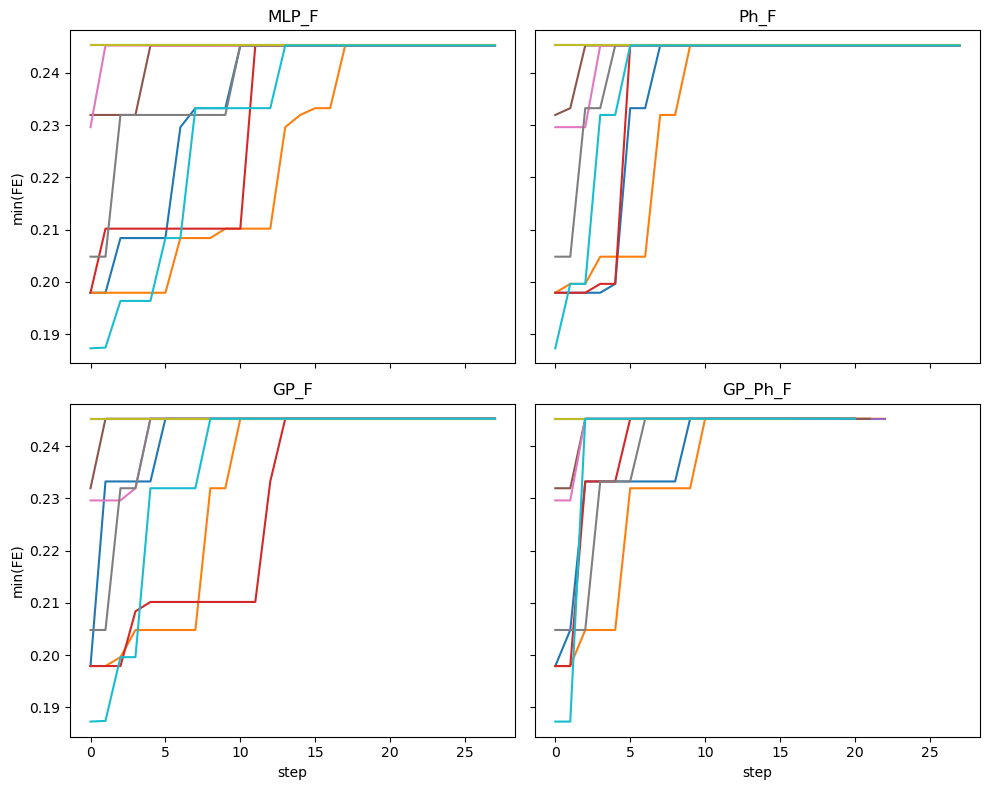

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex=True, sharey=True)
all_df = []
for i, dname in enumerate(['MLP_F', 'Ph_F', 'GP_F', 'GP_Ph_F']):
#for i, dname in enumerate(['MLP_F']):
    _df = process_runs_mean(Path(dname))
    _df = _df[_df['step']>=0]
    sns.lineplot(data=_df, x='step', y='cummax FE', hue='dname', legend=False, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(dname)
    ax[i//2, i%2].set_ylabel('min(FE)')
    all_df.append(_df)
all_df = pd.concat(all_df, axis=0)
fig.tight_layout()
plt.savefig('cummax_FE')
plt.show()

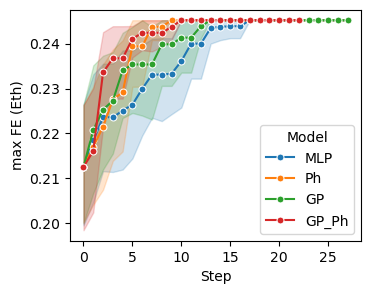

In [27]:
all_df['Model'] = all_df['dname'].map(lambda x: '_'.join(x.split('_')[:-1]))
plt.figure(figsize=(3.75,3))
sns.lineplot(data=all_df, x='step', y='cummax FE', hue='Model', marker='o', ms=5)
plt.ylabel('max FE (Eth)')
plt.xlabel('Step')
plt.savefig('./active-learning.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [24]:
# Export figure data for later comparison
import re
from pathlib import Path
import pandas as pd

models = ['MLP_F', 'Ph_F', 'GP_F', 'GP_Ph_F']
#models = ['MLP_F']  # for quick testing
out_dir = Path('./figure_data')
out_dir.mkdir(exist_ok=True)

all_dfs = []
for model in models:
    p = Path(model)
    if not p.exists():
        print(f'Skipping {model}: folder not found')
        continue

    df = process_runs_mean(p)
    # keep only non-negative steps (same as plotting code)
    df = df[df['step'] >= 0].copy()
    if df.empty:
        print(f'No data for {model}, skipping')
        continue

    # short label (e.g. 'MLP' from 'MLP_F')
    label = re.sub(r'_?F\d*$', '', model).rstrip('_')

    # write per-run rows: dname, step, cummax FE (tab-separated)
    out_file = out_dir / f'{label}_maxFE.txt'
    df.to_csv(out_file, sep='\t', index=False, columns=['dname', 'step', 'cummax FE'])

    # write mean and std across runs for each step (summary)
    summary = df.groupby('step')['cummax FE'].agg(['mean', 'std']).reset_index()
    summary_file = out_dir / f'{label}_maxFE_summary.txt'
    summary.to_csv(summary_file, sep='\t', index=False)

    # collect for combined file
    df2 = df[['dname', 'step', 'cummax FE']].copy()
    df2['model'] = label
    all_dfs.append(df2)

    print(f'Wrote {out_file} and {summary_file} (rows: {len(df)})')

if all_dfs:
    combined = pd.concat(all_dfs, axis=0)
    combined_file = out_dir / 'all_models_maxFE.txt'
    combined.to_csv(combined_file, sep='\t', index=False)
    print(f'Wrote combined {combined_file} (rows: {len(combined)})')
else:
    print('No model data written (no folders found or all empty)')

Wrote figure_data\MLP_maxFE.txt and figure_data\MLP_maxFE_summary.txt (rows: 253)
Wrote figure_data\Ph_maxFE.txt and figure_data\Ph_maxFE_summary.txt (rows: 253)
Wrote figure_data\GP_maxFE.txt and figure_data\GP_maxFE_summary.txt (rows: 253)
Wrote figure_data\GP_Ph_maxFE.txt and figure_data\GP_Ph_maxFE_summary.txt (rows: 187)
Wrote combined figure_data\all_models_maxFE.txt (rows: 946)
